# Plotting Few-Shot Model Evaluation Results

Assembling plots from summary files.

In [1]:
import os
import sys
import pandas as pd

# Setting up local details:
# This should be the location of the checkout of the FS-Mol repository:
FS_MOL_CHECKOUT_PATH = os.path.join(os.environ['HOME'], "ADKF-IFT")
# This should be the location of the FS-Mol dataset:
FS_MOL_DATASET_PATH = os.path.join(FS_MOL_CHECKOUT_PATH, "fs-mol-dataset")

os.chdir(FS_MOL_CHECKOUT_PATH)
sys.path.insert(0, FS_MOL_CHECKOUT_PATH)

from fs_mol.plotting.utils import (
    highlight_max_all, 
    plot_all_assays, 
    load_data,
    expand_values,
    plot_task_performances_by_id,
    box_plot,
    plot_by_size,
    get_aggregates_across_sizes,
    walltime_plot
)

## Making summary files

Summary files are obtained by running `fs_mol/plotting/collect_eval_runs.py` on the outputs of evaluation runs. If an evaluation output directory is "evaluation_output_directory" then summary files are created with: 

The option `--plot` results in a plot across support set sizes for each few-shot testing task. Final summarized results will be found in "evaluation_output_directory/summary/{model_name}_summary.csv"

## Loading the collated evaluation data

Create a dictionary of all model summary .csvs to be compared. The csvs are the final summaries from `collect_eval_runs.py`

In [2]:
# Configure this to contain all the models that you want to look at.
# Dict keys are human readable names, values are the path to the summary produced by collect_eval_runs.py
results_path = os.path.join(FS_MOL_CHECKOUT_PATH, "baselines")
output_path = os.path.join(FS_MOL_CHECKOUT_PATH, "visualize_results")

# a dictionary summarising all models to be compared. Add new paths here as desired.
model_summaries = {
    "ADKF-IFT": os.path.join(output_path, "ADKF-IFT/ADKF-IFT_regression_summary.csv"),
    "DKT": os.path.join(output_path, "DKT/DKT_regression_summary.csv"),
    "CNP": os.path.join(output_path, "CNP/CNP_regression_summary.csv"),
    "GP-ST": os.path.join(output_path, "GP-ST/GP-ST_regression_summary.csv"),
    "RF": os.path.join(output_path, "RF/RF_regression_summary.csv"),
    "GNN-MT": os.path.join(output_path, "GNN-MT/GNN-MT_regression_summary.csv"),
    "MAT": os.path.join(output_path, "MAT/MAT_regression_summary.csv"),
    "DKL": os.path.join(output_path, "DKL/DKL_regression_summary.csv")
}
# Generated plots will be stored here, if you want to keep them. None disables saving.
plot_output_dir = os.path.join(output_path, "plots/regression")
all_tasks_output_dir = os.path.join(plot_output_dir, "all_tasks")
os.makedirs(plot_output_dir, exist_ok=True)
os.makedirs(all_tasks_output_dir, exist_ok=True)

In [3]:
data = load_data(model_summaries, numeric=True)

Loading data for ADKF-IFT from /homes/wc337/FS-Mol-ADKT/visualize_results/ADKF-IFT/ADKF-IFT_regression_summary.csv.
Loading data for DKT from /homes/wc337/FS-Mol-ADKT/visualize_results/DKT/DKT_regression_summary.csv.
Loading data for CNP from /homes/wc337/FS-Mol-ADKT/visualize_results/CNP/CNP_regression_summary.csv.
Loading data for GP-ST from /homes/wc337/FS-Mol-ADKT/visualize_results/GP-ST/GP-ST_regression_summary.csv.
Loading data for RF from /homes/wc337/FS-Mol-ADKT/visualize_results/RF/RF_regression_summary.csv.
Loading data for GNN-MT from /homes/wc337/FS-Mol-ADKT/visualize_results/GNN-MT/GNN-MT_regression_summary.csv.
Loading data for MAT from /homes/wc337/FS-Mol-ADKT/visualize_results/MAT/MAT_regression_summary.csv.
Loading data for DKL from /homes/wc337/FS-Mol-ADKT/visualize_results/DKL/DKL_regression_summary.csv.


/homes/wc337/FS-Mol-ADKT/fs_mol/plotting/utils.py:560: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  merged_df = merge_loaded_dfs(df_list, numeric=numeric)


## Highlight the best result for each task

In [4]:
styled_df = data.style.apply(lambda row: highlight_max_all(row), axis=1)
# To save for exporting purposes, uncomment this (requires `pip install xlsxwriter`)
styled_df.to_excel(os.path.join(plot_output_dir, f"highlighted_comparison.xlsx"), engine='xlsxwriter')

styled_df

,TASK_ID,16_train (ADKF-IFT),32_train (ADKF-IFT),64_train (ADKF-IFT),128_train (ADKF-IFT),256_train (ADKF-IFT),16_train (DKT),32_train (DKT),64_train (DKT),128_train (DKT),256_train (DKT),16_train (CNP),32_train (CNP),64_train (CNP),128_train (CNP),256_train (CNP),16_train (GP-ST),32_train (GP-ST),64_train (GP-ST),128_train (GP-ST),256_train (GP-ST),16_train (RF),32_train (RF),64_train (RF),128_train (RF),256_train (RF),16_train (GNN-MT),32_train (GNN-MT),64_train (GNN-MT),128_train (GNN-MT),256_train (GNN-MT),16_train (MAT),32_train (MAT),64_train (MAT),128_train (MAT),256_train (MAT),16_train (DKL),32_train (DKL),64_train (DKL),128_train (DKL),256_train (DKL)
0,1066254,0.226+/-0.081,0.381+/-0.06,0.58+/-0.036,0.659+/-0.127,nan,0.249+/-0.081,0.419+/-0.109,0.586+/-0.035,0.637+/-0.146,nan,0.003+/-0.013,0.001+/-0.014,0.007+/-0.017,0.009+/-0.064,nan,0.142+/-0.175,0.339+/-0.143,0.579+/-0.037,0.641+/-0.099,nan,0.121+/-0.093,0.276+/-0.128,0.471+/-0.073,0.565+/-0.161,nan,0.008+/-0.094,0.053+/-0.137,0.379+/-0.144,0.559+/-0.146,nan,-0.238+/-0.284,-0.058+/-0.198,0.097+/-0.142,0.104+/-0.266,nan,0.107+/-0.249,0.142+/-0.135,0.465+/-0.061,0.617+/-0.09,nan
1,1119333,0.386+/-0.088,0.469+/-0.051,0.554+/-0.046,0.655+/-0.019,0.726+/-0.028,0.358+/-0.061,0.438+/-0.048,0.527+/-0.048,0.634+/-0.024,0.709+/-0.027,0.039+/-0.024,0.031+/-0.012,0.039+/-0.009,0.042+/-0.011,0.034+/-0.029,0.246+/-0.153,0.398+/-0.07,0.524+/-0.064,0.64+/-0.026,0.706+/-0.019,0.28+/-0.157,0.424+/-0.067,0.516+/-0.057,0.604+/-0.04,0.662+/-0.036,0.113+/-0.097,0.247+/-0.09,0.358+/-0.08,0.454+/-0.034,0.569+/-0.054,-0.016+/-0.178,0.038+/-0.438,0.369+/-0.059,0.387+/-0.122,0.467+/-0.146,0.31+/-0.131,0.402+/-0.075,0.439+/-0.082,0.52+/-0.045,0.645+/-0.049
2,1243967,0.355+/-0.064,0.51+/-0.045,0.645+/-0.034,0.703+/-0.051,nan,0.398+/-0.056,0.488+/-0.046,0.585+/-0.029,0.639+/-0.048,nan,0.046+/-0.008,0.046+/-0.01,0.041+/-0.015,0.033+/-0.042,nan,0.115+/-0.074,0.235+/-0.099,0.355+/-0.035,0.421+/-0.099,nan,0.112+/-0.057,0.22+/-0.081,0.333+/-0.031,0.415+/-0.101,nan,-0.198+/-0.293,-0.02+/-0.218,0.145+/-0.089,0.2+/-0.134,nan,-0.074+/-0.192,-0.042+/-0.247,0.134+/-0.11,0.132+/-0.167,nan,0.095+/-0.09,0.184+/-0.086,0.217+/-0.133,0.293+/-0.138,nan
3,1243970,0.295+/-0.063,0.373+/-0.062,0.481+/-0.026,0.567+/-0.046,nan,0.319+/-0.083,0.371+/-0.071,0.451+/-0.026,0.541+/-0.048,nan,0.037+/-0.011,0.033+/-0.008,0.025+/-0.017,0.025+/-0.027,nan,0.096+/-0.088,0.112+/-0.099,0.209+/-0.042,0.351+/-0.075,nan,0.049+/-0.083,0.148+/-0.046,0.229+/-0.097,0.317+/-0.074,nan,-0.094+/-0.162,0.012+/-0.123,0.14+/-0.093,0.263+/-0.115,nan,-0.248+/-0.331,-0.043+/-0.084,0.083+/-0.102,0.143+/-0.083,nan,0.089+/-0.052,0.068+/-0.096,0.125+/-0.1,0.26+/-0.099,nan
4,1613777,-0.006+/-0.04,0.022+/-0.028,0.021+/-0.024,0.038+/-0.025,0.062+/-0.019,-0.016+/-0.037,0.014+/-0.039,0.009+/-0.037,0.017+/-0.038,0.025+/-0.04,-0.035+/-0.033,-0.024+/-0.012,-0.026+/-0.007,-0.026+/-0.007,-0.023+/-0.005,0.004+/-0.024,0.008+/-0.018,0.023+/-0.029,0.033+/-0.055,0.068+/-0.022,-0.045+/-0.088,-0.006+/-0.046,0.02+/-0.043,0.024+/-0.054,0.07+/-0.022,-0.276+/-0.32,-0.166+/-0.189,-0.157+/-0.13,-0.145+/-0.084,-0.075+/-0.082,-0.279+/-0.331,-0.124+/-0.157,-0.145+/-0.122,-0.153+/-0.144,-0.056+/-0.074,-0.062+/-0.069,-0.083+/-0.069,-0.168+/-0.112,-0.195+/-0.091,-0.174+/-0.089
5,1613800,-0.016+/-0.034,-0.001+/-0.022,-0.001+/-0.014,0.015+/-0.022,0.034+/-0.01,-0.026+/-0.041,-0.026+/-0.036,-0.02+/-0.016,-0.021+/-0.016,-0.014+/-0.023,-0.021+/-0.009,-0.025+/-0.003,-0.026+/-0.005,-0.029+/-0.004,-0.028+/-0.007,-0.0+/-0.0,-0.002+/-0.007,-0.006+/-0.013,0.005+/-0.01,0.023+/-0.015,-0.044+/-0.062,-0.024+/-0.051,-0.01+/-0.024,-0.009+/-0.03,0.008+/-0.029,-0.217+/-0.173,-0.155+/-0.117,-0.134+/-0.083,-0.1+/-0.072,-0.048+/-0.041,-0.296+/-0.356,-0.119+/-0.111,-0.128+/-0.115,-0.083+/-0.091,-0.057+/-0.053,-0.057+/-0.036,-0.113+/-0.062,-0.129+/-0.035,-0.17+/-0.048,-0.214+/-0.049
6,1613898,0.007+/-0.044,0.027+/-0.022,0.064+/-0.028,0.071+/-0.047,nan,0.044+/-0.05,0.062+/-0.038,0.066+/-0.046,0.008+/-0.1

In [5]:
# expand out from val +/- error format, and calculate delta AUPRC
data = expand_values(data, model_summaries, numeric=True)

## Performance Overview over all Tasks

This compares with the trivial baseline of using a weighted coinflip according to the class imbalance in the training data.

In [6]:
# This uses Latex to render plots, and requires the type1ec and type1cm packages.
# It also required the dvipng utility.
# On Debian/Ubuntu-based systems, this can be installed using `apt install cm-super texlive-latex-extra dvipng`

#plot_task_performances_by_id(data, model_summaries, support_set_size = 16)

### Incorporate protein information

Our test tasks have associated target protein information available. We can merge this data to allow plotting with specific EC number classes highlighted.

In [7]:
protein_path = os.path.join(FS_MOL_CHECKOUT_PATH, "datasets/targets", "test_proteins.csv")
ecs = pd.read_csv(protein_path)
ecs["target_id"] = ecs["target_id"].astype(int).astype(str)
ecs["chembl_id"] = ecs["chembl_id"].astype(str)
ecs["TASK_ID"] = ecs.apply(lambda row: row["chembl_id"][6:], axis = 1)

data = ecs.merge(data, on="TASK_ID")

In [8]:
# the highlight class is the EC class that will be highlighted in the resulting plot. 
# You may wish to use this for comparison across different EC classes.
# plot_task_performances_by_id(data, model_summaries, support_set_size = 16, highlight_class = 2)

## Plot for each task, comparing different models

This makes an individual comparison plot over models for each few-shot testing task, across all support set sizes available. 

**Warning** Not to use lightly, it will take a few minutes to complete

In [9]:
# plot_all_assays(data, model_summaries.keys(), results_dir = all_tasks_output_dir)

# Summarise the overall performance in box plots

This reproduces the model comparison box plots in the manuscript.

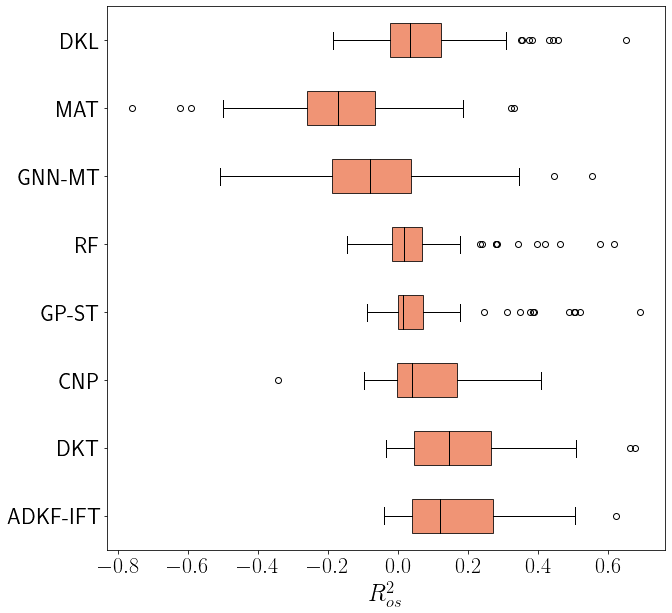

In [10]:
box_plot(data, model_summaries, support_set_size = 16, plot_output_dir=plot_output_dir, numeric=True)

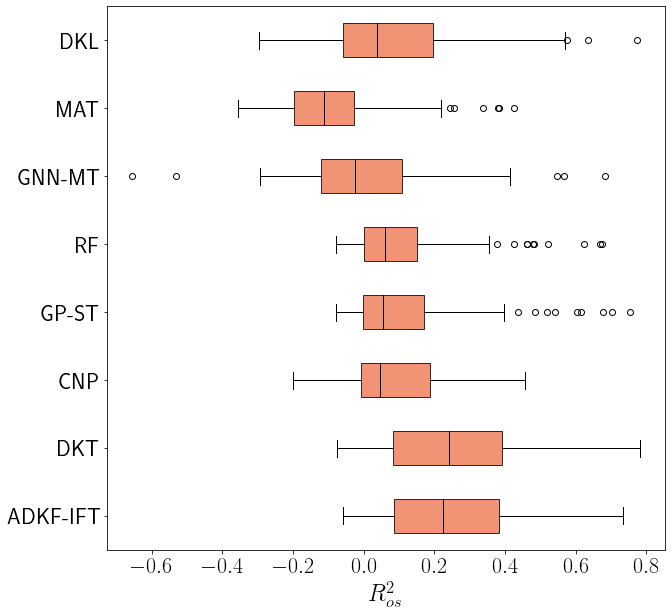

In [11]:
box_plot(data, model_summaries, support_set_size = 32, plot_output_dir=plot_output_dir, numeric=True)

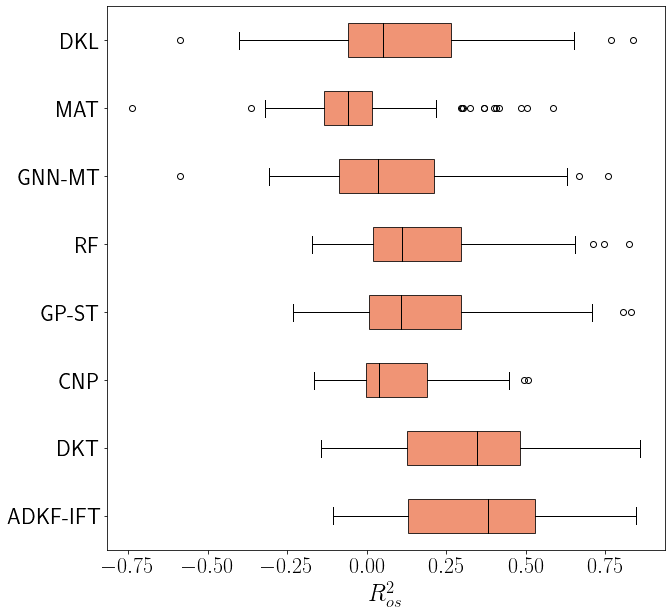

In [12]:
box_plot(data, model_summaries, support_set_size = 64, plot_output_dir=plot_output_dir, numeric=True)

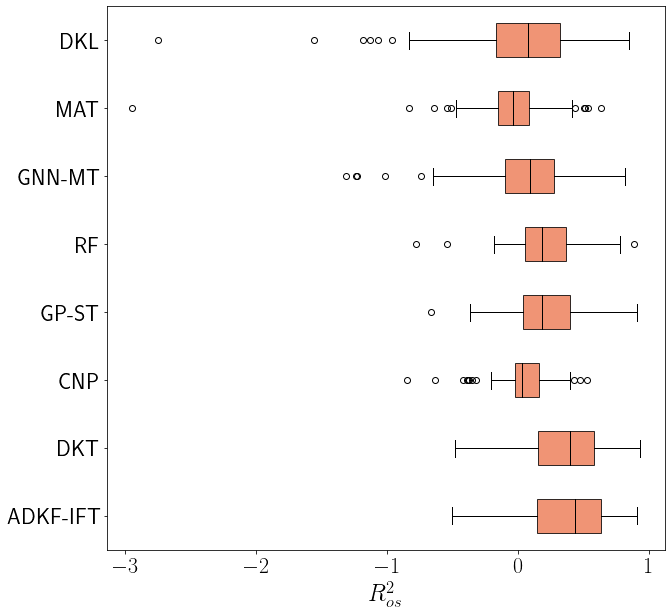

In [13]:
box_plot(data, model_summaries, support_set_size = 128, plot_output_dir=plot_output_dir, numeric=True)

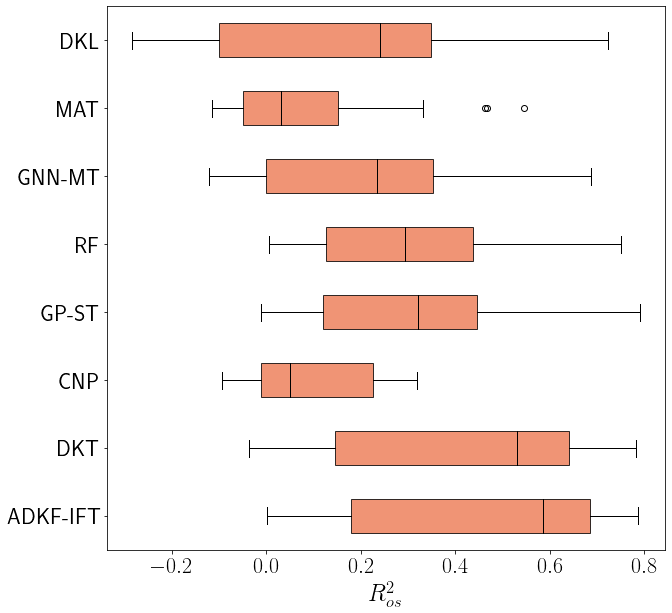

In [14]:
box_plot(data, model_summaries, support_set_size = 256, plot_output_dir=plot_output_dir, numeric=True)

## Aggregate as a function of the number of training points, across all categories

Here the results are aggregated according to EC class, and across all classes. This is used to plot the variation of performance with support set size, comparing all models in the model_summaries dictionary. 

In [15]:
aggregate_df = get_aggregates_across_sizes(data, model_summaries, numeric=True)

In [16]:
# show results of Table 2 for support set size 16
cols = [x for x  in aggregate_df.columns if x.startswith("16")]
aggregate_df[cols]

,16_train (ADKF-IFT),16_train (DKT),16_train (CNP),16_train (GP-ST),16_train (RF),16_train (GNN-MT),16_train (MAT),16_train (DKL),16_train (ADKF-IFT) std,16_train (DKT) std,16_train (CNP) std,16_train (GP-ST) std,16_train (RF) std,16_train (GNN-MT) std,16_train (MAT) std,16_train (DKL) std
EC_category,,,,,,,,,,,,,,,,
3,0.177105,0.179895,0.013684,0.126053,0.101316,-0.087211,-0.157000,0.103526,0.040758,0.044842,0.014039,0.039072,0.041858,0.047956,0.049138,0.041524
2,0.174524,0.184902,0.109963,0.055366,0.045988,-0.046110,-0.166854,0.061951,0.015202,0.015770,0.014883,0.013395,0.011713,0.018528,0.018835,0.014764
1,0.043833,0.033667,-0.017167,0.020333,-0.010167,-0.146000,-0.183667,-0.011833,0.036251,0.034182,0.008455,0.017765,0.024676,0.036233,0.041549,0.028892
4,0.237000,0.261500,0.088000,0.251000,0.208500,0.009000,-0.094000,0.169500,0.224000,0.247500,0.070000,0.254000,0.253500,0.243000,0.199000,0.212500
5,0.096000,0.067000,-0.016000,0.008000,0.035000,-0.088000,-0.187000,0.040000,0.047000,0.061000,0.017000,0.017000,0.050000,0.170000,0.129000,0.079000
6,0.063000,0.066000,0.000000,-0.007000,-0.008000,-0.219000,-0.165000,0.000000,0.056000,0.069000,0.008000,0.068000,0.063000,0.262000,0.258000,0.062000
all,0.167315,0.175117,0.084090,0.068108,0.054766,-0.059486,-0.164928,0.066261,0.013921,0.014771,0.012068,0.012860,0.012079,0.016524,0.016507,0.013556


In [17]:
cols = [x for x  in aggregate_df.columns if x.startswith("32")]
aggregate_df[cols]

,32_train (ADKF-IFT),32_train (DKT),32_train (CNP),32_train (GP-ST),32_train (RF),32_train (GNN-MT),32_train (MAT),32_train (DKL),32_train (ADKF-IFT) std,32_train (DKT) std,32_train (CNP) std,32_train (GP-ST) std,32_train (RF) std,32_train (GNN-MT) std,32_train (MAT) std,32_train (DKL) std
EC_category,,,,,,,,,,,,,,,,
3,0.251105,0.243895,0.013895,0.201105,0.179895,-0.003000,-0.045158,0.123158,0.054511,0.056223,0.014749,0.052904,0.051076,0.051796,0.044889,0.058098
2,0.266890,0.263098,0.119841,0.096524,0.096134,0.001573,-0.099427,0.066085,0.019581,0.018907,0.015694,0.017127,0.014945,0.021476,0.016032,0.019996
1,0.087333,0.077000,-0.016333,0.058667,0.043000,-0.127833,-0.106000,0.001333,0.058767,0.061869,0.007632,0.049478,0.047331,0.038210,0.032043,0.071331
4,0.360500,0.362000,0.098500,0.343000,0.310500,0.157000,0.040500,0.288000,0.340500,0.349000,0.071500,0.360000,0.313500,0.391000,0.296500,0.346000
5,0.151000,0.137000,-0.010000,0.057000,0.059000,0.029000,-0.091000,0.020000,0.059000,0.095000,0.010000,0.076000,0.050000,0.081000,0.176000,0.170000
6,0.181000,0.181000,0.001000,0.063000,0.082000,-0.077000,-0.006000,0.107000,0.036000,0.030000,0.004000,0.070000,0.075000,0.139000,0.110000,0.060000
all,0.254351,0.249658,0.091721,0.116162,0.111000,-0.003865,-0.087054,0.076306,0.018364,0.018214,0.012770,0.017018,0.015301,0.019162,0.014843,0.018940


In [18]:
cols = [x for x  in aggregate_df.columns if x.startswith("64")]
aggregate_df[cols]

,64_train (ADKF-IFT),64_train (DKT),64_train (CNP),64_train (GP-ST),64_train (RF),64_train (GNN-MT),64_train (MAT),64_train (DKL),64_train (ADKF-IFT) std,64_train (DKT) std,64_train (CNP) std,64_train (GP-ST) std,64_train (RF) std,64_train (GNN-MT) std,64_train (MAT) std,64_train (DKL) std
EC_category,,,,,,,,,,,,,,,,
3,0.310105,0.295316,0.013526,0.266526,0.255684,0.064789,0.059263,0.168053,0.061811,0.063389,0.014773,0.060542,0.058459,0.062106,0.051561,0.072211
2,0.363073,0.342841,0.126732,0.161671,0.159537,0.075317,-0.047220,0.093524,0.023738,0.022044,0.017310,0.021751,0.019258,0.023207,0.019717,0.026314
1,0.116167,0.097833,-0.012333,0.102500,0.107833,-0.083667,-0.084833,-0.001833,0.078616,0.077635,0.011090,0.076258,0.086958,0.034253,0.020745,0.101343
4,0.442000,0.440000,0.099500,0.416500,0.418000,0.239500,0.237500,0.367500,0.403000,0.418000,0.067500,0.415500,0.405000,0.426500,0.349500,0.401500
5,0.226000,0.209000,-0.012000,0.086000,0.125000,0.028000,-0.058000,0.098000,0.063000,0.113000,0.010000,0.082000,0.077000,0.105000,0.113000,0.107000
6,0.279000,0.277000,0.002000,0.202000,0.182000,-0.016000,0.020000,0.114000,0.043000,0.035000,0.004000,0.079000,0.040000,0.084000,0.063000,0.074000
all,0.340090,0.321414,0.096973,0.180694,0.177748,0.066631,-0.025387,0.106288,0.022091,0.021273,0.013947,0.020721,0.019149,0.021234,0.018294,0.024460


In [19]:
cols = [x for x  in aggregate_df.columns if x.startswith("128")]
aggregate_df[cols]

,128_train (ADKF-IFT),128_train (DKT),128_train (CNP),128_train (GP-ST),128_train (RF),128_train (GNN-MT),128_train (MAT),128_train (DKL),128_train (ADKF-IFT) std,128_train (DKT) std,128_train (CNP) std,128_train (GP-ST) std,128_train (RF) std,128_train (GNN-MT) std,128_train (MAT) std,128_train (DKL) std
EC_category,,,,,,,,,,,,,,,,
3,0.366211,0.349368,0.010316,0.324421,0.299211,0.146737,0.097158,0.175263,0.070171,0.071692,0.015691,0.068567,0.062530,0.062999,0.053254,0.099569
2,0.400646,0.375720,0.057427,0.208171,0.207610,0.018988,-0.108390,-0.028768,0.030543,0.028853,0.025371,0.028110,0.026985,0.044708,0.044685,0.059775
1,0.156167,0.135833,-0.016333,0.145833,0.158333,-0.036000,-0.075833,-0.034500,0.091927,0.094620,0.010035,0.089407,0.094081,0.047067,0.021465,0.115277
4,0.501000,0.496500,0.105000,0.472000,0.461500,0.360000,0.269500,0.424000,0.412000,0.433500,0.064000,0.440000,0.422500,0.455000,0.364500,0.421000
5,0.276000,0.296000,-0.011000,0.253000,0.195000,0.151000,-0.026000,0.233000,0.053000,0.067000,0.009000,0.052000,0.051000,0.043000,0.131000,0.096000
6,0.364000,0.350000,0.004000,0.317000,0.229000,0.122000,0.073000,0.149000,0.044000,0.039000,0.004000,0.040000,0.047000,0.067000,0.127000,0.111000
all,0.381892,0.359468,0.045135,0.230838,0.225279,0.046144,-0.062261,0.017964,0.026926,0.026068,0.019071,0.025371,0.024055,0.035768,0.035526,0.048680


In [20]:
cols = [x for x  in aggregate_df.columns if x.startswith("256")]
aggregate_df[cols]

,256_train (ADKF-IFT),256_train (DKT),256_train (CNP),256_train (GP-ST),256_train (RF),256_train (GNN-MT),256_train (MAT),256_train (DKL),256_train (ADKF-IFT) std,256_train (DKT) std,256_train (CNP) std,256_train (GP-ST) std,256_train (RF) std,256_train (GNN-MT) std,256_train (MAT) std,256_train (DKL) std
EC_category,,,,,,,,,,,,,,,,
3,0.259714,0.231143,-0.029857,0.228000,0.222714,0.087000,0.072857,0.019571,0.109271,0.112967,0.017143,0.113290,0.104265,0.100901,0.081447,0.148371
2,0.555903,0.521806,0.141387,0.359419,0.345032,0.272258,0.100581,0.250677,0.039104,0.038159,0.021444,0.034557,0.033918,0.033684,0.027373,0.042949
1,0.074250,0.034000,-0.022250,0.067750,0.063250,-0.050250,-0.035750,-0.182500,0.027852,0.035835,0.002955,0.028123,0.031410,0.021742,0.021933,0.040580
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.459000,0.442000,0.003000,0.430000,0.362000,0.229000,0.142000,0.305000,0.019000,0.024000,0.008000,0.029000,0.034000,0.070000,0.088000,0.070000
all,0.460628,0.427256,0.095070,0.312535,0.299302,0.211093,0.084349,0.174023,0.041391,0.041235,0.019396,0.033533,0.032187,0.033159,0.024127,0.044239


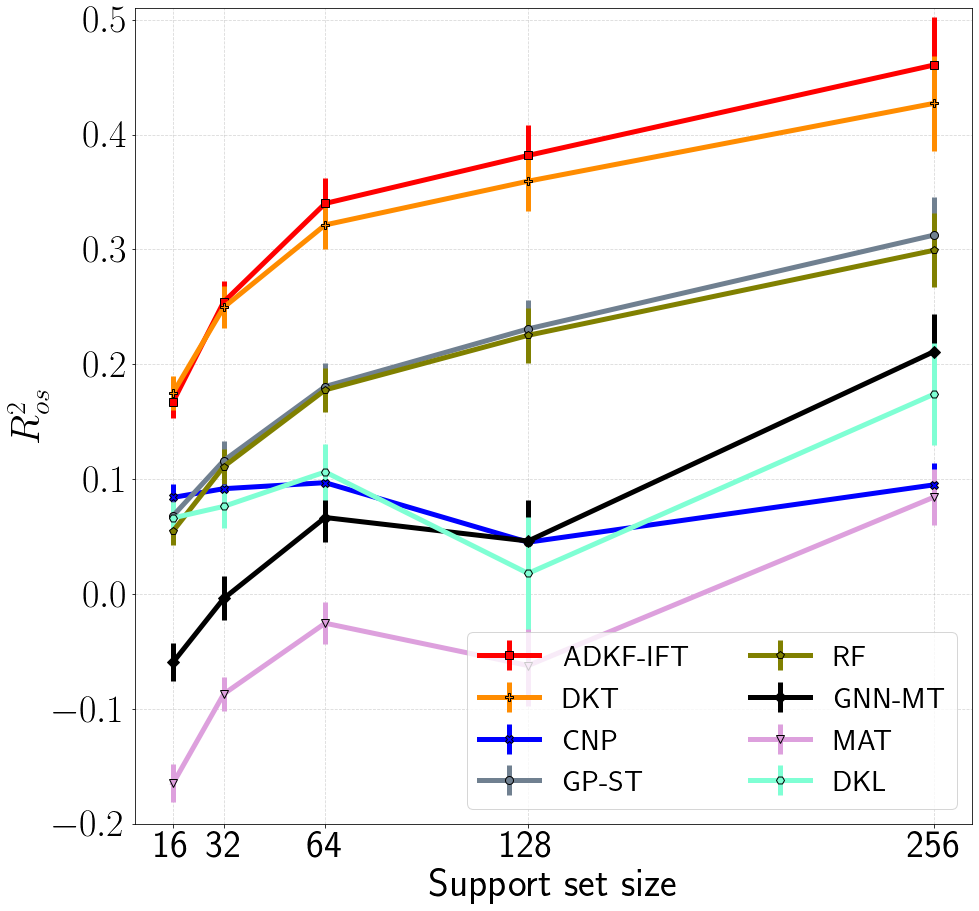

In [21]:
# this function has the option to plot all classes separately.
plot_by_size(aggregate_df, model_summaries, plot_output_dir = plot_output_dir, numeric=True)

# Ranking

Here we use [autorank](https://pypi.org/project/autorank/) for an appropriate comparison between all methods when evaluated on multiple tasks.


In [22]:
from autorank import autorank

# select correct data to rank with autorank
for size in [16, 32, 64, 128, 256]:

    df = data[[x for x in list(data.columns) if x.startswith(f"{size}") and "val" in x and "r2" in x]]
    result = autorank(df, verbose=False, alpha=0.1)
    print(result.rankdf["meanrank"])
    print()

16_train (MAT) val r2         7.603604
16_train (GNN-MT) val r2      6.612613
16_train (RF) val r2          5.000000
16_train (DKL) val r2         4.418919
16_train (GP-ST) val r2       4.225225
16_train (CNP) val r2         3.878378
16_train (ADKF-IFT) val r2    2.144144
16_train (DKT) val r2         2.117117
Name: meanrank, dtype: float64

32_train (MAT) val r2         7.454955
32_train (GNN-MT) val r2      6.396396
32_train (DKL) val r2         5.157658
32_train (RF) val r2          4.468468
32_train (CNP) val r2         4.445946
32_train (GP-ST) val r2       4.135135
32_train (DKT) val r2         2.081081
32_train (ADKF-IFT) val r2    1.860360
Name: meanrank, dtype: float64

64_train (MAT) val r2         7.261261
64_train (GNN-MT) val r2      6.153153
64_train (DKL) val r2         5.626126
64_train (CNP) val r2         4.950450
64_train (RF) val r2          4.162162
64_train (GP-ST) val r2       3.873874
64_train (DKT) val r2         2.288288
64_train (ADKF-IFT) val r2    1.684685


In [23]:
from scipy.stats import wilcoxon

# select correct data to rank with autorank
for size in [16, 32, 64, 128, 256]:

    df = data[[x for x in list(data.columns) if (x.startswith(f"{size}_train (ADKF-IFT)") or x.startswith(f"{size}_train (DKT)")) and "val" in x and "r2" in x]]
    df = df.dropna()
    diff = df.iloc[:,1] - df.iloc[:,0]
    diff = diff.to_numpy()
    print("number of tasks:", len(df))
    print("wilcoxon (two-sided):", wilcoxon(diff).pvalue)
    #print(create_report(result))
    print()

number of tasks: 111
wilcoxon (two-sided): 0.08229650257920491

number of tasks: 111
wilcoxon (two-sided): 0.09573999670727207

number of tasks: 111
wilcoxon (two-sided): 3.737638206897399e-05

number of tasks: 111
wilcoxon (two-sided): 7.068818972169298e-05

number of tasks: 43
wilcoxon (two-sided): 9.809423349350156e-07



In [24]:
data["EC_super_class_name"].value_counts()

transferase       82
hydrolase         19
oxidoreductase     6
lyase              2
isomerase          1
ligase             1
Name: EC_super_class_name, dtype: int64